70

In [1]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

--2021-06-29 19:51:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  25.5MB/s    in 1.1s    

2021-06-29 19:51:29 (25.5 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   
【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
N

In [2]:
import gdown
from gensim.models import KeyedVectors

# 学習済み単語ベクトルのダウンロード
url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=True)

# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [3]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10684, 300])
tensor([[ 0.0837,  0.0056,  0.0068,  ...,  0.0751,  0.0433, -0.0868],
        [ 0.0272,  0.0266, -0.0947,  ..., -0.1046, -0.0489, -0.0092],
        [ 0.0577, -0.0159, -0.0780,  ..., -0.0421,  0.1229,  0.0876],
        ...,
        [ 0.0392, -0.0052,  0.0686,  ..., -0.0175,  0.0061, -0.0224],
        [ 0.0798,  0.1017,  0.1066,  ..., -0.0752,  0.0623,  0.1138],
        [ 0.1664,  0.0451,  0.0508,  ..., -0.0531, -0.0183, -0.0039]])


In [4]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)


torch.Size([10684])
tensor([0, 1, 3,  ..., 0, 3, 2])


In [5]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

71

In [6]:
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

In [7]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.2814, 0.0521, 0.2356, 0.4309]], grad_fn=<SoftmaxBackward>)
tensor([[0.2814, 0.0521, 0.2356, 0.4309],
        [0.0966, 0.0517, 0.6682, 0.1836],
        [0.4605, 0.2003, 0.1484, 0.1908],
        [0.0697, 0.6554, 0.1816, 0.0933]], grad_fn=<SoftmaxBackward>)


72

In [8]:
criterion = nn.CrossEntropyLoss()

l_1 = criterion(model(X_train[:1]), y_train[:1])  # 入力ベクトルはsoftmax前の値
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 1.2681
勾配:
tensor([[-0.0601, -0.0040, -0.0049,  ..., -0.0540, -0.0311,  0.0624],
        [ 0.0044,  0.0003,  0.0004,  ...,  0.0039,  0.0023, -0.0045],
        [ 0.0197,  0.0013,  0.0016,  ...,  0.0177,  0.0102, -0.0205],
        [ 0.0361,  0.0024,  0.0029,  ...,  0.0324,  0.0187, -0.0374]])


In [14]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 2.9437
勾配:
tensor([[-0.0233,  0.0011,  0.0013,  ..., -0.0193, -0.0085,  0.0205],
        [-0.0043, -0.0017,  0.0268,  ...,  0.0280,  0.0205, -0.0043],
        [ 0.0363, -0.0114, -0.0299,  ...,  0.0023,  0.0252,  0.0099],
        [-0.0088,  0.0119,  0.0018,  ..., -0.0109, -0.0372, -0.0261]])


73

In [9]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [10]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [11]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()

  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

epoch: 1, loss_train: 0.4722, loss_valid: 0.3684
epoch: 2, loss_train: 0.3126, loss_valid: 0.3341
epoch: 3, loss_train: 0.2825, loss_valid: 0.3170
epoch: 4, loss_train: 0.2661, loss_valid: 0.3155
epoch: 5, loss_train: 0.2560, loss_valid: 0.3100
epoch: 6, loss_train: 0.2486, loss_valid: 0.3107
epoch: 7, loss_train: 0.2432, loss_valid: 0.3101
epoch: 8, loss_train: 0.2386, loss_valid: 0.3093
epoch: 9, loss_train: 0.2358, loss_valid: 0.3102
epoch: 10, loss_train: 0.2328, loss_valid: 0.3083


74

In [12]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.925
正解率（評価データ）：0.905


75

In [13]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3255, accuracy_train: 0.8886, loss_valid: 0.3459, accuracy_valid: 0.8825
epoch: 2, loss_train: 0.2852, accuracy_train: 0.9012, loss_valid: 0.3223, accuracy_valid: 0.8892
epoch: 3, loss_train: 0.2673, accuracy_train: 0.9084, loss_valid: 0.3110, accuracy_valid: 0.8930
epoch: 4, loss_train: 0.2532, accuracy_train: 0.9138, loss_valid: 0.3017, accuracy_valid: 0.8975
epoch: 5, loss_train: 0.2440, accuracy_train: 0.9169, loss_valid: 0.3005, accuracy_valid: 0.8960
epoch: 6, loss_train: 0.2386, accuracy_train: 0.9185, loss_valid: 0.3001, accuracy_valid: 0.8967
epoch: 7, loss_train: 0.2388, accuracy_train: 0.9178, loss_valid: 0.3051, accuracy_valid: 0.8945
epoch: 8, loss_train: 0.2319, accuracy_train: 0.9227, loss_valid: 0.2999, accuracy_valid: 0.8990
epoch: 9, loss_train: 0.2267, accuracy_train: 0.9226, loss_valid: 0.2995, accuracy_valid: 0.9004
epoch: 10, loss_train: 0.2249, accuracy_train: 0.9247, loss_valid: 0.3015, accuracy_valid: 0.9004
epoch: 11, loss_train: 0.2255

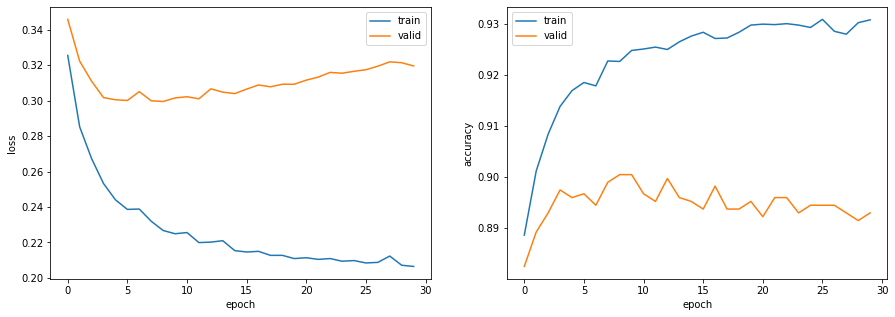

In [14]:
from matplotlib import pyplot as plt
import numpy as np
# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

76

In [15]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3277, accuracy_train: 0.8851, loss_valid: 0.3604, accuracy_valid: 0.8743
epoch: 2, loss_train: 0.2852, accuracy_train: 0.9015, loss_valid: 0.3283, accuracy_valid: 0.8870
epoch: 3, loss_train: 0.2642, accuracy_train: 0.9088, loss_valid: 0.3160, accuracy_valid: 0.8877
epoch: 4, loss_train: 0.2546, accuracy_train: 0.9106, loss_valid: 0.3140, accuracy_valid: 0.8900
epoch: 5, loss_train: 0.2454, accuracy_train: 0.9176, loss_valid: 0.3104, accuracy_valid: 0.8900
epoch: 6, loss_train: 0.2373, accuracy_train: 0.9203, loss_valid: 0.3067, accuracy_valid: 0.8945
epoch: 7, loss_train: 0.2325, accuracy_train: 0.9226, loss_valid: 0.3068, accuracy_valid: 0.8937
epoch: 8, loss_train: 0.2290, accuracy_train: 0.9244, loss_valid: 0.3056, accuracy_valid: 0.8960
epoch: 9, loss_train: 0.2257, accuracy_train: 0.9248, loss_valid: 0.3042, accuracy_valid: 0.8967
epoch: 10, loss_train: 0.2316, accuracy_train: 0.9209, loss_valid: 0.3151, accuracy_valid: 0.8922


77

In [16]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}


# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3339, accuracy_train: 0.8851, loss_valid: 0.3690, accuracy_valid: 0.8743, 5.4253sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3041, accuracy_train: 0.8950, loss_valid: 0.3483, accuracy_valid: 0.8825, 2.9486sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2954, accuracy_train: 0.8958, loss_valid: 0.3425, accuracy_valid: 0.8840, 1.5465sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2903, accuracy_train: 0.9015, loss_valid: 0.3379, accuracy_valid: 0.8870, 0.8645sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2885, accuracy_train: 0.9019, loss_valid: 0.3367, accuracy_valid: 0.8870, 0.4904sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2874, accuracy_train: 0.9017, loss_valid: 0.3364, accuracy_valid: 0.8840, 0.3077sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2870, accuracy_train: 0.9019, loss_valid: 0.3361, accuracy_valid: 0.8847, 0.2106sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2870, accuracy_train: 0.9020, loss_valid: 0.3360, accuracy_valid: 0.8847, 0.1626sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2861, accuracy_

78

In [17]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [18]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1, device=device)

バッチサイズ: 1
epoch: 1, loss_train: 0.3337, accuracy_train: 0.8813, loss_valid: 0.3606, accuracy_valid: 0.8795, 13.0756sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3035, accuracy_train: 0.8966, loss_valid: 0.3368, accuracy_valid: 0.8847, 6.5567sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2926, accuracy_train: 0.8995, loss_valid: 0.3293, accuracy_valid: 0.8930, 3.2985sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2885, accuracy_train: 0.9009, loss_valid: 0.3265, accuracy_valid: 0.8885, 1.7329sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2863, accuracy_train: 0.9013, loss_valid: 0.3252, accuracy_valid: 0.8915, 0.9373sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2854, accuracy_train: 0.9016, loss_valid: 0.3246, accuracy_valid: 0.8922, 0.5361sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2851, accuracy_train: 0.9015, loss_valid: 0.3244, accuracy_valid: 0.8930, 0.3174sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2840, accuracy_train: 0.9015, loss_valid: 0.3243, accuracy_valid: 0.8937, 0.2190sec
バッチサイズ: 256
epoch: 1, loss_train: 0.2844, accuracy

79

In [22]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)


epoch: 1, loss_train: 0.8277, accuracy_train: 0.7693, loss_valid: 0.8159, accuracy_valid: 0.7777, 0.5458sec
epoch: 2, loss_train: 0.6699, accuracy_train: 0.7785, loss_valid: 0.6644, accuracy_valid: 0.7829, 0.5284sec
epoch: 3, loss_train: 0.6041, accuracy_train: 0.7851, loss_valid: 0.6029, accuracy_valid: 0.7897, 0.5485sec
epoch: 4, loss_train: 0.5625, accuracy_train: 0.7966, loss_valid: 0.5647, accuracy_valid: 0.8001, 0.5164sec
epoch: 5, loss_train: 0.5256, accuracy_train: 0.8104, loss_valid: 0.5315, accuracy_valid: 0.8099, 0.5225sec
epoch: 6, loss_train: 0.4979, accuracy_train: 0.8268, loss_valid: 0.5063, accuracy_valid: 0.8226, 0.5041sec
epoch: 7, loss_train: 0.4743, accuracy_train: 0.8355, loss_valid: 0.4851, accuracy_valid: 0.8308, 0.5132sec
epoch: 8, loss_train: 0.4510, accuracy_train: 0.8503, loss_valid: 0.4640, accuracy_valid: 0.8383, 0.5111sec
epoch: 9, loss_train: 0.4349, accuracy_train: 0.8581, loss_valid: 0.4500, accuracy_valid: 0.8488, 0.5124sec
epoch: 10, loss_train: 0.414